# Current Approach

Given a population of susceptible individuals with heterogeneous acquisition risk, we calculate the running cumulative sum of the risk factors (inherently normalized to 1.0?) and then draw N samples from the range [0, total).

For each sample, we find the index of the individual whose "bucket" in the running cumulative sum contains that sample.

## Example

Suppose we have the following individuals:

|ID|relative risk|
|--|-------------|
|0 | 1.0         |
|1 | 0.5         |
|2 | 0.75        |
|3 | 1.5         |
|4 | 1.0         |
|5 | 1.0         |
|6 | 0.5         |
|7 | 0.5         |
|8 | 1.25        |
|9 | 0.5         |
|10| 0.75        |
|11| 1.25        |
|12| 1.25        |
|13| 0.5         |
|14| 0.75        |
|15| 0.75        |

Our running cumulative sum looks like this:

[ 1.  ,  1.5 ,  2.25,  3.75,  4.75,  5.75,  6.25,  6.75,  8.  ,  8.5 ,  9.25, 10.5 , 11.75, 12.25, 13.  , 13.75]

Geometrically it looks like this (55 1/4s):

```text
####XX###XXXXXX####XXXX##XX#####XX###XXXXX#####XX###XXX
                                         1    1 1  1  1
   1 1  2     3   4   5 6 6    8 8  9    0    1 2  3  3
   . .  .     .   .   . . .    . .  .    .    . .  .  .
   0 5  2     7   7   7 2 7    0 5  2    5    7 2  0  7
   0 0  5     5   5   5 5 5    0 0  5    0    5 5  0  5
```

The buckets for agents 8, 11 and 12 with acquisition risk 1.25 take up proportionally more room than, say, the agents 1, 6, 7, 9, and 13 with acquisition risk 0.5.

Each draw is then in the range [0, 13.75) and relatively more likely to land in one of the larger buckets than one of the smaller buckets.

In [41]:
import numpy as np

# i = np.random.choice([0.5, 0.75, 1.0, 1.25, 1.5], 16)
i = np.array(
    [
        1.0,
        0.5,
        0.75,
        1.5,
        1.0,
        1.0,
        0.5,
        0.5,
        1.25,
        0.5,
        0.75,
        1.25,
        1.25,
        0.5,
        0.75,
        0.75,
    ],
    dtype=np.float32,
)
print(f"{i=}")
cs = np.cumsum(i)
print(f"{cs=}")


i=array([1.  , 0.5 , 0.75, 1.5 , 1.  , 1.  , 0.5 , 0.5 , 1.25, 0.5 , 0.75,
       1.25, 1.25, 0.5 , 0.75, 0.75], dtype=float32)
cs=array([ 1.  ,  1.5 ,  2.25,  3.75,  4.75,  5.75,  6.25,  6.75,  8.  ,
        8.5 ,  9.25, 10.5 , 11.75, 12.25, 13.  , 13.75], dtype=float32)


Let's generate 10M individuals with relative acquisition risks drawn from the set above.


In [42]:
N = 10_000_000
susceptible = np.random.choice([0.5, 0.75, 1.0, 1.25, 1.5], N).astype(np.float32)
print(f"{susceptible[0:32]=}")
print(f"{susceptible[-32:]=}")

susceptible[0:32]=array([1.25, 0.75, 0.5 , 0.5 , 1.25, 1.  , 1.  , 1.25, 0.75, 0.75, 0.5 ,
       0.75, 1.5 , 1.  , 1.  , 1.  , 0.75, 1.25, 1.25, 0.75, 1.25, 1.25,
       0.75, 1.25, 0.75, 1.5 , 0.75, 1.  , 1.5 , 1.  , 0.5 , 0.75],
      dtype=float32)
susceptible[-32:]=array([0.75, 1.  , 0.5 , 0.5 , 1.5 , 1.25, 1.  , 1.5 , 0.5 , 1.  , 1.5 ,
       1.5 , 1.  , 0.5 , 1.5 , 0.75, 1.25, 1.  , 1.  , 1.5 , 1.  , 0.75,
       1.5 , 1.5 , 0.75, 1.  , 1.25, 1.5 , 1.  , 0.5 , 0.5 , 1.5 ],
      dtype=float32)


We calculate the running cumulative sum and draw a number of samples in the range of [0, total).

In [43]:
cs = np.cumsum(susceptible.astype(np.float64))
print(f"{cs[-1]=}")
S = 1_000
samples = np.random.random(size=S) * cs[-1]  # .astype(np.float32)
print(f"{samples[0:8]=}")
print(f"{samples[-8:]=}")

cs[-1]=np.float64(9999272.0)
samples[0:8]=array([8344024.34612469, 4610683.43222613, 6248156.05542181,
       3831359.54786873, 2852236.52870601, 9913919.63555811,
       9109772.84897971, 2642103.19980689])
samples[-8:]=array([1839550.8613885 , 4491712.44462825, 9686951.33324052,
       2224295.10559038,   71562.52082454, 6288199.73089029,
       5632382.91314699, 2217526.87887756])


Now, for each sample, we find the index of the "bucket" into which it falls.

We'll also make sure we are using `searchsorted()` correctly with a value which should be in the first bucket (index == 0) and a value which should be in the last bucket (index == 9,999,999).

In [44]:
first = np.searchsorted(cs, cs[0] / 2, side="right")
print(f"{first=}")
last = np.searchsorted(cs, (cs[-2] + cs[-1]) / 2, side="right")
print(f"{last=}")
indices = np.searchsorted(cs, samples, side="right")
print(f"{len(indices)=}")
print(f"{len(np.unique(indices))=}")


first=np.int64(0)
last=np.int64(9999999)
len(indices)=1000
len(np.unique(indices))=1000


Let's see if the statistics seem right.

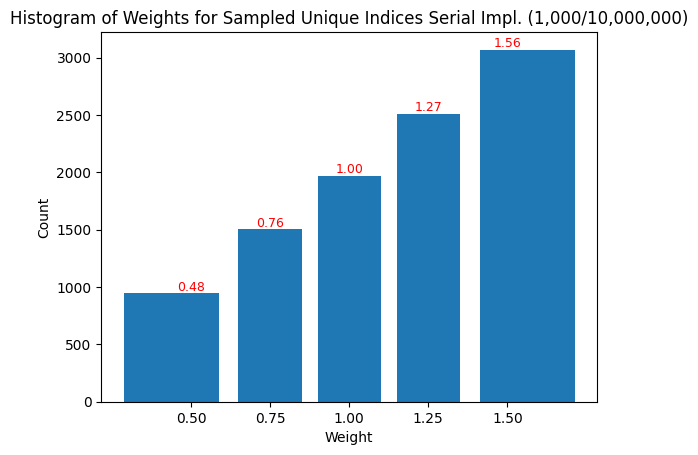

In [53]:
import matplotlib.pyplot as plt

unique_indices = np.unique(indices)
weights = susceptible[unique_indices]

bins = [0.25, 0.625, 0.875, 1.125, 1.375, 1.75]
centers = [0.5, 0.75, 1.0, 1.25, 1.5]

plt.hist(weights, bins=bins, rwidth=0.8)

counts, _ = np.histogram(weights, bins=bins)
ratio_to_third = counts / counts[2]

for idx, (center, count, ratio) in enumerate(zip(centers, counts, ratio_to_third)):
    plt.text(
        center, count, f"{ratio:.2f}", ha="center", va="bottom", fontsize=9, color="red"
    )

plt.xticks(centers)
plt.xlabel("Weight")
plt.ylabel("Count")
plt.title(f"Histogram of Weights for Sampled Unique Indices Serial Impl. ({S:,}/{N:,})")
plt.show()

That's roughly right. Let's sample 10_000 times to get better(?) statistics.

dt=0.011421 s
indices=array([    599,    1948,    3711, ..., 9999053, 9999459, 9999959],
      shape=(10000,), dtype=uint32)


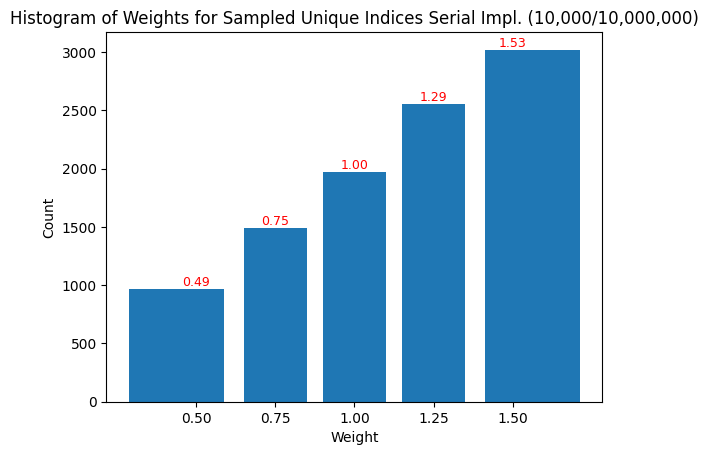

In [ ]:
from time import perf_counter_ns

MS = 10_000
indices = []
t0 = perf_counter_ns()
nuniq = 0
while nuniq < MS:
    nsample = MS - nuniq
    samples = np.random.random(size=nsample) * cs[-1]  # .astype(np.float32)
    newindices = np.searchsorted(cs, samples, side="right")
    indices = np.unique(np.concatenate((indices, newindices))).astype(np.uint32)
    nuniq = len(indices)
    # print(f"{nuniq=}")
t1 = perf_counter_ns()
dt = (t1 - t0) / 1e9
print(f"{dt=:.6f} s")

print(f"{indices=}")
weights = susceptible[indices]

bins = [0.25, 0.625, 0.875, 1.125, 1.375, 1.75]
centers = [0.5, 0.75, 1.0, 1.25, 1.5]

plt.hist(weights, bins=bins, rwidth=0.8)

counts, _ = np.histogram(weights, bins=bins)
ratio_to_third = counts / counts[2]

for idx, (center, count, ratio) in enumerate(zip(centers, counts, ratio_to_third)):
    plt.text(
        center, count, f"{ratio:.2f}", ha="center", va="bottom", fontsize=9, color="red"
    )

plt.xticks(centers)
plt.xlabel("Weight")
plt.ylabel("Count")
plt.title(
    f"Histogram of Weights for Sampled Unique Indices Serial Impl. ({MS:,}/{N:,})"
)
plt.show()

A little better.

# Parallel Approach



In [47]:
import numba as nb


@nb.njit((nb.float32[:], nb.float32, nb.uint8[:]), nogil=True, parallel=True)
def nb_sample(risk, rate, infected):
    for i in nb.prange(len(risk)):
        krate = risk[i] * rate
        pinf = -np.expm1(-krate)
        draw = np.random.random()
        if draw < pinf:
            infected[i] = 1

    return


dt=0.005415 s
np.sum(infected)=np.uint64(10043)


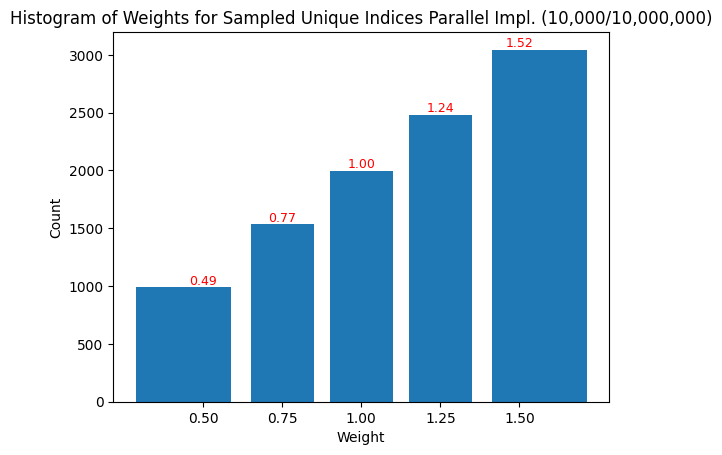

In [79]:
# we already have risk (susceptible), let's make up a rate
NINF = 10_000
rate = NINF / len(susceptible)
infected = np.zeros(len(susceptible), dtype=np.uint8)

t0 = perf_counter_ns()
nb_sample(susceptible, rate, infected)
t1 = perf_counter_ns()
dt = (t1 - t0) / 1e9
print(f"{dt=:.6f} s")
print(f"{np.sum(infected)=}")

weights = susceptible[infected == 1]

bins = [0.25, 0.625, 0.875, 1.125, 1.375, 1.75]
centers = [0.5, 0.75, 1.0, 1.25, 1.5]

plt.hist(weights, bins=bins, rwidth=0.8)

counts, _ = np.histogram(weights, bins=bins)
ratio_to_third = counts / counts[2]

for idx, (center, count, ratio) in enumerate(zip(centers, counts, ratio_to_third)):
    plt.text(
        center, count, f"{ratio:.2f}", ha="center", va="bottom", fontsize=9, color="red"
    )

plt.xticks(centers)
plt.xlabel("Weight")
plt.ylabel("Count")
plt.title(
    f"Histogram of Weights for Sampled Unique Indices Parallel Impl. ({NINF:,}/{N:,})"
)
plt.show()

Looks pretty good, IMO.

Re. the total number of infections: With rate 10,000 / 10,000,000 = 0.001, p(inf) = 1 - e<sup>-0.001</sup> = 0.0009995002 so we might expect a little fewer than 10,000 new infections.

In [49]:
# from tqdm import tqdm
from alive_progress import alive_bar
from alive_progress import config_handler

config_handler.set_global(force_tty=True)

count = 1024
sum = 0
# for _ in tqdm(range(count)):
with alive_bar(count, title="Doing work") as bar:
    for i in range(count):
        inf = np.zeros(len(susceptible), dtype=np.uint8)
        nb_sample(susceptible, rate, inf)
        if count <= 10:
            print(f"{np.sum(inf)=}")
        sum += np.sum(inf)
        bar()

print(f"{np.round(sum/count)=}")


Doing work |████████████████████████████████████████| 1024/1024 [100%] in 5.0s (
np.round(sum/count)=np.float64(9992.0)


Let's try a Taichi implementation on the GPU.

In [50]:
import taichi as ti

ti.init(arch=ti.gpu, default_fp=ti.f32)

risk_taichi = ti.field(dtype=ti.f32, shape=len(susceptible))
infected_taichi = ti.field(dtype=ti.u8, shape=len(susceptible))


@ti.func
def expm1(x: ti.f32) -> ti.f32:  # type: ignore
    retval = ti.f32(float("nan"))

    # tiny = 1.19209e-07 / 2.0    # float64 epsilon = 2.22045e-16
    # if ti.abs(x) < tiny:        # tiny64 = 1.110225e-16
    if ti.abs(x) < 5.96045e-8:
        retval = x

    elif ti.abs(x) <= 1e-5:
        # 5th-order Taylor: x + x^2/2! + x^3/3! + x^4/4! + x^5/5!
        # Horner form for fewer mults:
        # x * (1 + x/2 * (1 + x/3 * (1 + x/4 * (1 + x/5))))
        c5 = 1.0 / 5.0
        c4 = 1.0 / 4.0
        c3 = 1.0 / 3.0
        c2 = 1.0 / 2.0

        u = 1.0 + x * c5
        u = 1.0 + x * c4 * u
        u = 1.0 + x * c3 * u
        u = 1.0 + x * c2 * u

        retval = x * u

    else:
        # otherwise, just use exp
        retval = ti.exp(x) - 1

    return retval


@ti.kernel
def taichi_sample(risk: ti.template(), rate: ti.f32, infected: ti.template()):  # type: ignore
    for i in range(risk.shape[0]):
        krate = risk[i] * rate
        pinf = -expm1(-krate)
        draw = ti.random()
        if draw < pinf:
            infected[i] = ti.u8(1)
    return


[Taichi] Starting on arch=metal


dt=0.001021 s
np.sum(infected)=np.uint64(10026)


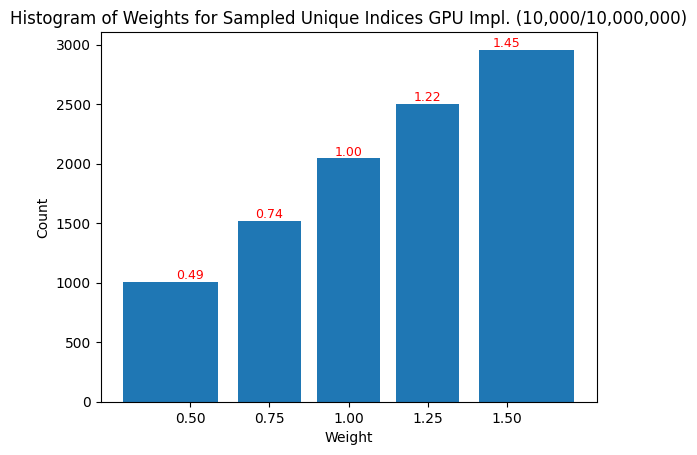

In [56]:
# Let's warm up Taichi with a small run
risk_taichi.from_numpy(susceptible)
infected_taichi.fill(0)
taichi_sample(risk_taichi, rate, infected_taichi)

risk_taichi.from_numpy(susceptible)
infected_taichi.fill(0)
ti.sync()

t0 = perf_counter_ns()
rate = NINF / len(susceptible)
taichi_sample(risk_taichi, rate, infected_taichi)
ti.sync()
t1 = perf_counter_ns()
dt = (t1 - t0) / 1e9
print(f"{dt=:.6f} s")

infected = infected_taichi.to_numpy()
print(f"{np.sum(infected)=}")

weights = susceptible[infected == 1]

bins = [0.25, 0.625, 0.875, 1.125, 1.375, 1.75]
centers = [0.5, 0.75, 1.0, 1.25, 1.5]

plt.hist(weights, bins=bins, rwidth=0.8)

counts, _ = np.histogram(weights, bins=bins)
ratio_to_third = counts / counts[2]

for idx, (center, count, ratio) in enumerate(zip(centers, counts, ratio_to_third)):
    plt.text(
        center, count, f"{ratio:.2f}", ha="center", va="bottom", fontsize=9, color="red"
    )

plt.xticks(centers)
plt.xlabel("Weight")
plt.ylabel("Count")
plt.title(f"Histogram of Weights for Sampled Unique Indices GPU Impl. ({NINF:,}/{N:,})")
plt.show()

In [52]:
from tqdm import tqdm

count = 1024
sum = 0
for i in tqdm(range(count)):
    infected_taichi.fill(0)
    taichi_sample(risk_taichi, rate, infected_taichi)
    cinf = np.sum(infected_taichi.to_numpy())
    if count <= 10:
        print(f"{cinf=}")
    sum += cinf

print(f"{np.round(sum/count)=}")


100%|██████████| 1024/1024 [00:04<00:00, 249.61it/s]

np.round(sum/count)=np.float64(9990.0)
